# <center> Обучение с учителем. Классификация
## <center> Случайный лес в sklearn

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики

Конечно же, ансамблевые алгоритмы вручную пишут очень редко. Для этого есть библиотеки, такие как `sklearn`. 

В sklearn все ансамблевые методы реализованы в модуле `ensemble`. Давайте импортируем его:

In [2]:
from sklearn import ensemble #ансамбли

Будем работать с датасетом о диабете:

In [3]:
diabetes_data = pd.read_csv('data/diabetes_cleaned.csv')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98.0,58.0,33.0,34.0,0.430,43,0
1,2,112.0,75.0,32.0,35.7,0.148,21,0
2,2,108.0,64.0,29.0,30.8,0.158,21,0
3,8,107.0,80.0,29.0,24.6,0.856,34,0
4,7,136.0,90.0,29.0,29.9,0.210,50,0


По традиции сначала построим модель на двух признаках (`Glucose` и `BMI`) и посмотрим, как будет выглядеть разделяющая поверхность случайного леса.

In [4]:
#Создаём матрицу наблюдений X и столбец с ответами y
X = diabetes_data[['Glucose', 'BMI']]
y = diabetes_data['Outcome']

В библиотеке `sklearn` модель случайного леса для решения задачи классификации реализована в классе `RandomForestClassifier`.

**Основные параметры RandomForestClassifier:**

* `n_estimators` — количество деревьев в лесу (число K из бэггинга; по умолчанию равно 100);
* `criterion` — критерий информативности разбиения для каждого из деревьев (`'gini'` — критерий Джини и `'entropy'` — энтропия Шеннона; по умолчанию — `'gini'`);
* `max_depth` — максимальная глубина одного дерева (по умолчанию — `None`, то есть глубина дерева не ограничена);
* `max_features` — максимальное число признаков, которые будут использоваться каждым из деревьев (число L из метода случайных подпространств; по умолчанию — `'sqrt'`; для обучения каждого из деревьев используется $\sqrt{m}$ признаков, где $m$ — число признаков в начальном наборе данных);
* `min_samples_leaf` — минимальное число объектов в листе (по умолчанию — 1);
* `random_state` — параметр, отвечающий за генерацию случайных чисел.

Давайте создадим лес из 500 деревьев решений с максимальной глубиной 3. В качестве критерия информативности будем использовать энтропию. Число признаков в каждом дереве будем вычислять как $\sqrt{m}$.

Затем обучим модель случайного леса с помощью метода `fit()`, сделаем предсказание классов с помощью метода `predict()` и рассчитаем метрики.

In [5]:
#Создаём объект класса случайный лес
rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=3, #максимальная глубина дерева
    max_features='sqrt', #число признаков из метода случайных подространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_2d.fit(X, y)

#Делаем предсказание класса
y_pred = rf_clf_2d.predict(X)
#Выводим отчёт о метриках
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.84       493
           1       0.73      0.57      0.64       264

    accuracy                           0.78       757
   macro avg       0.76      0.73      0.74       757
weighted avg       0.77      0.78      0.77       757



> К сожалению, визуализировать то, как случайный лес принимает решение, как мы это делали с одним деревом решений, у нас не получится, так как в таком случае пришлось бы визуализировать 500 деревьев.

Однако мы можем построить разделяющую поверхность нашего леса, воспользовавшись функцией `plot_probabilities_2d()`:

c:\Users\Настенька\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


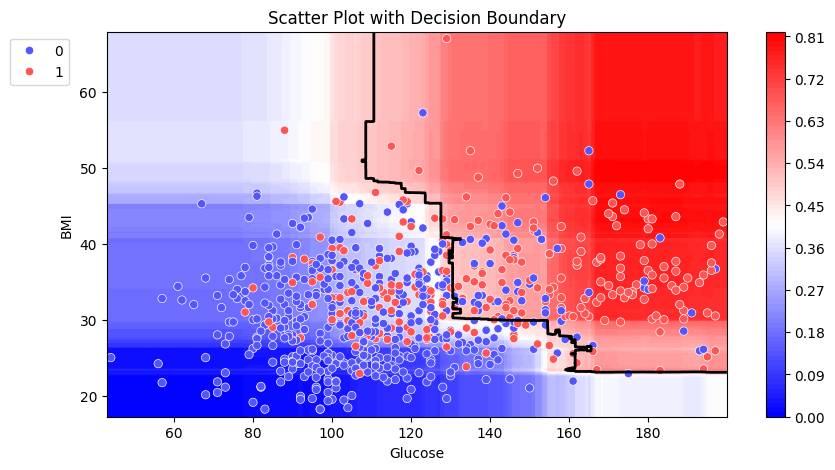

In [6]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку.
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линия, где вероятность равна 0.5.
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))
plot_probabilities_2d(X, y, rf_clf_2d)

> Обратите внимание на то, как отличаются разделяющие поверхности одного дерева решений и целого леса из деревьев. При этом их максимальная глубина и критерии информативности идентичны. Эта разделяющая поверхность вычисляется на основе усреднения 500 различных разделяющих поверхностей базовых моделей. 

А теперь используем для предсказания все признаки из набора данных:

In [7]:
#Создаём матрицу признаков X и столбец с ответами y
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']

In [8]:
#Создаём объект класса RanndomForest
rf_clf_full = ensemble.RandomForestClassifier(
    n_estimators=300, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=6, #максимальная глубина дерева
    max_features='sqrt', #число признаков из метода случайных подространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_full.fit(X, y)

#Делаем предсказание класса
y_pred = rf_clf_full.predict(X)
#Выводим отчёт о метриках
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       493
           1       0.85      0.77      0.80       264

    accuracy                           0.87       757
   macro avg       0.86      0.85      0.85       757
weighted avg       0.87      0.87      0.87       757



> Сравните полученные метрики с метриками простого дерева решений той же глубины и тем же критерием информативности, которое мы использовали в прошлом юните. 

Если мы захотим предсказывать не классы, а вероятности, чтобы, например, подобрать оптимальный порог вероятности, то сработает уже знакомый нам метод `predict_proba()`:

In [9]:
rf_clf_full.predict_proba(X)

array([[0.7186633 , 0.2813367 ],
       [0.85222366, 0.14777634],
       [0.88358167, 0.11641833],
       ...,
       [0.28908312, 0.71091688],
       [0.44280536, 0.55719464],
       [0.94476689, 0.05523311]])

Метод возвращает вероятности принадлежности к классам 0 и 1 (отсутствие и наличие диабета соответственно) для каждого объекта из выборки.

> К сожалению, визуализировать построенный лес в виде дерева, как и построить разделяющую поверхность леса, не получится. Это утверждение относится ко всем ансамблевым алгоритмам. Человеку сложно понять, по какому принципу ансамбль принимает решение. Это один из основных их недостатков. 

Однако так как случайный лес основан на деревьях решений, у него также есть атрибут `feature_importances_`, в котором находятся коэффициенты важности каждого из признаков. Давайте построим столбчатую диаграмму, иллюстрирующую показатели важности для каждого признака.

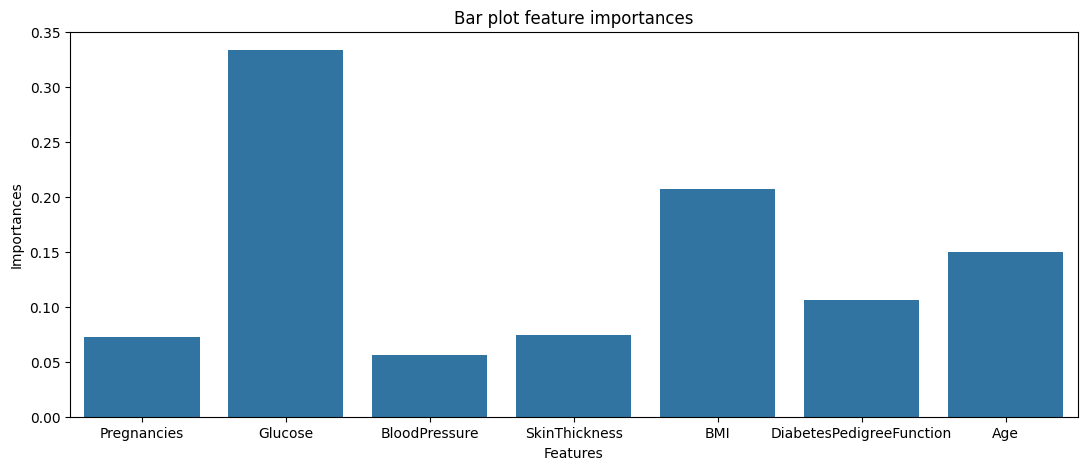

In [10]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X.columns #признаки
feature_importances = rf_clf_full.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

> Обратите внимание, что важность признаков для одного дерева и леса из деревьев могут отличаться. Случайный лес даёт более объективную картину об информативности признаков, так как информативность считается не по одному дереву, а по всей совокупности ансамбля.